In [1]:
import time
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

from fbprophet import Prophet


## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Using TensorFlow backend.


In [3]:
train_df=pd.read_csv('C:/Users/Dell/Downloads/datascience/demand-forecasting-kernels-only/train.csv')
test_df=pd.read_csv("C:/Users/Dell/Downloads/datascience/demand-forecasting-kernels-only/test.csv")
sample_df=pd.read_csv("C:/Users/Dell/Downloads/datascience/demand-forecasting-kernels-only/sample_submission.csv")

In [4]:
sample_df.shape

(45000, 2)

In [5]:
train_df.shape

(913000, 4)

In [6]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
def sales_dist(data):
    sales_df=data.copy(deep=True)
    sales_df['sales_bins']=pd.cut(sales_df.sales,[0,50,100,150,200,250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    return sales_df
sales_df=sales_dist(train_df)
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005
Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

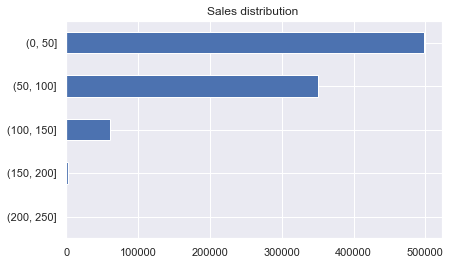

In [8]:
sales_count=pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh',title='Sales distribution ' )

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                   ...                        \
item          7          8          9          10  ...         41         42   
store                                              ...                         
1      52.783680  69.472070  46.504929  66.354326  ...  20.002738  33.105696   
2      75.058598  99.090361  65.478094  94.097481  ...  28.069551  47.368018   
3      66.647864  87.517525  58.486857  83.387733  ...  24.989047  41.797371   
4      61.625411  80.819825  54.043812  77.047645  ...  23.168127  38.539978   
5      44.535597  58.565717  38.837349  55.509858  ...  16.830778  27.730559   
6      44.599124  58.385542  39.460022  55.565170  ...  16.607338  27.893209   
7      40.709748  53.723987  35.901972  51.156627  ...  15.471522  25.435926   
8      71.730559  94.461117  63.193319  89.818182  ...  27.036145  45.144031   
9      61.812158  81.287514  54.105696  77.105148  ...  23.191128  38.643483   
10     65.807777  86.176889  57.886637  82.232202  ...  24.654984  41.222892   

                                                                          \
item          43         44          45         46         47         48   
store                                                                      
1      46.242607  26.594195   72.720701  52.845016  19.814348  46.546002   
2      65.785323  37.785871  103.381161  75.219606  28.187842  66.028478   
3      58.197700  33.386090   91.851041  66.748083  25.120482  58.700986   
4      54.018620  30.952355   84.687295  61.420044  23.114458  53.765608   
5      39.163198  22.415115   61.427163  44.734940  16.699343  39.281490   
6      39.034502  22.322563   61.142935  44.539978  16.708653  39.052574   
7      35.426068  20.446331   55.905805  40.828587  15.479189  35.624315   
8      62.980285  36.194414   98.941402  72.004929  27.150055  62.737130   
9      54.152793  30.968237   85.093647  62.010953  23.003286  53.976999   
10     57.942497  32.916758   90.690581  66.046550  24.755750  57.814896   

                             
item          49         50  
store                        
1      26.461665  59.342826  
2      37.711939  84.622125  
3      33.259584  74.958379  
4      30.840635  68.921687  
5      22.371851  50.319277  
6      22.181271  50.516429  
7      20.406353  45.823658  
8      36.035049  80.972070  
9      31.052574  69.308324  
10     33.032311  74.037240  

[10 rows x 50 columns]

<Figure size 1440x720 with 0 Axes>

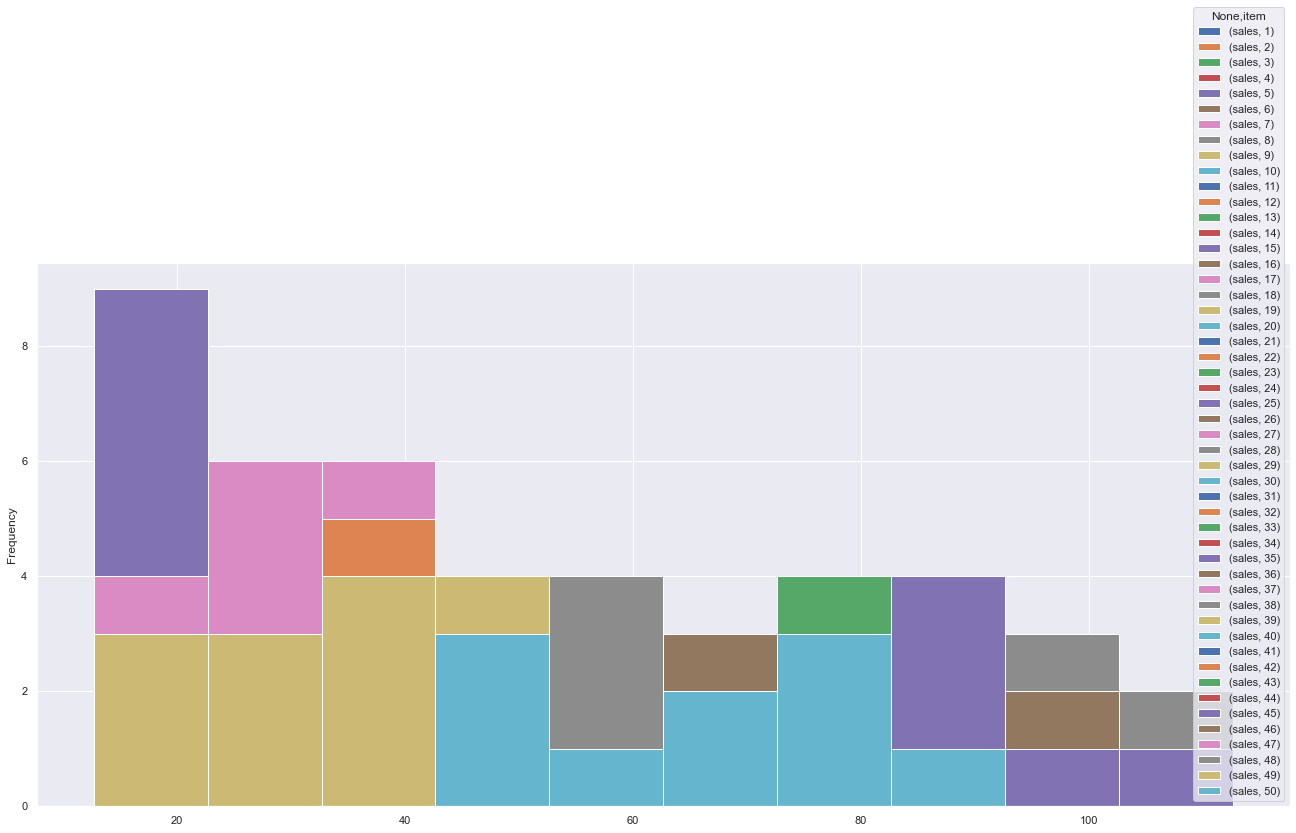

In [9]:
def sales_data_understanding(data):    
    store_df = data.copy()
    plt.figure(figsize=(20,10))
    sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
    sales_pivoted_df.plot(kind="hist",figsize=(20,10))
    # Pivoted dataframe
    display(sales_pivoted_df)
    return (store_df,sales_pivoted_df)

store_df,sales_pivoted_df = sales_data_understanding(train_df)

In [11]:
sales_across_store_df=sales_pivoted_df.copy()

In [12]:
sales_across_store_df['avg_sale']=sales_across_store_df.apply(lambda r:r.mean(),axis=1)

In [24]:
sales_store_data=go.Scatter(y=sales_across_store_df.avg_sale.values,
                           mode='markers',
                           marker=dict(
                           size=sales_across_store_df.avg_sale.values,
                           color=sales_across_store_df.avg_sale.values,
                           colorscale='Viridis',
                           showscale=True),
                               text = sales_across_store_df.index.values
)
data=sales_store_data
sales_store_layout=go.Layout(
autosize=True,
title="scatter plot",
hovermode='closest',
xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,),
    
    
    
    
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend=False)
fig=go.Figure(data=data,layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

In [27]:
def sales_insight(sales_pivoted_df):
    sales_across_item_df = sales_pivoted_df.copy()
    sales_across_item_df.loc[11]=sales_across_item_df.apply(lambda r:r.mean(),axis=0)
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    display(avg_sales_per_item_across_stores_df.head())
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)
sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


In [32]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

In [34]:
def Time_visualization(data):
    store_item_df = data.copy()
    # First, let us filterout the required data
    store_id = 10   # Some store
    item_id = 40    # Some item
    print('Before filter:', store_item_df.shape)
    store_item_df = store_item_df[store_item_df.store == store_id]
    store_item_df = store_item_df[store_item_df.item == item_id]
    print('After filter:', store_item_df.shape)
    #display(store_item_df.head())

    # Let us plot this now
    store_item_ts_data = [go.Scatter(
        x=store_item_df.date,
        y=store_item_df.sales)]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train_df)

Before filter: (913000, 4)
After filter: (1826, 4)


In [36]:
def sales_monthly(data):
    multi_store_item_df=data.copy()
    store_ids=[1,1,1,1]
    item_ids = [10, 20, 30, 40]
    print('Before filter:',multi_store_item_df.shape)
    multi_store_item_df=multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
    multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
    print("after filter: ",multi_store_item_df.shape)
    multi_store_item_ts_data=[]
    for st,it in zip(store_ids,item_ids):
        flt=multi_store_item_df[multi_store_item_df.store==st]
        flt = flt[flt.item == it]
        multi_store_item_ts_data.append(go.Scatter(x=flt.date,y=flt.sales,name="Store:"+",Item"+str(it)))
        py.iplot(multi_store_item_ts_data)
    return (multi_store_item_df)

multi_store_item_df = sales_monthly(train_df)

Before filter: (913000, 4)
after filter:  (7304, 4)


In [38]:
def split_data(train_data,test_data):
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])

    train_data['month'] = train_data['date'].dt.month
    train_data['day'] = train_data['date'].dt.dayofweek
    train_data['year'] = train_data['date'].dt.year

    test_data['month'] = test_data['date'].dt.month
    test_data['day'] = test_data['date'].dt.dayofweek
    test_data['year'] = test_data['date'].dt.year

    col = [i for i in test_data.columns if i not in ['date','id']]
    y = 'sales'
    train_x, test_x, train_y, test_y = train_test_split(train_data[col],train_data[y], test_size=0.2, random_state=2018)
    return (train_x, test_x, train_y, test_y,col)

train_x, test_x, train_y, test_y,col = split_data(train_df,test_df)

In [40]:
train_x.shape,test_x.shape

((730400, 5), (182600, 5))

In [44]:
train_x=np.array(train_x).reshape(train_x.shape[0],1,train_x.shape[1])
test_x=np.array(test_x).reshape(test_x.shape[0],1,test_x.shape[1])
train_x.shape,test_x.shape

((730400, 1, 5), (182600, 1, 5))

In [48]:
_optimiser=['Adam','Nadam','RMSprop']
model=Sequential()
model.add(LSTM(144, batch_input_shape=(32, 1, 5), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer=_optimiser[0])
model.summary()
model.fit(train_x,train_y,batch_size=32,epochs=5)
model.predict(train_x)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (32, 144)                 86400     
_________________________________________________________________
dense_3 (Dense)              (32, 1)                   145       
Total params: 86,545
Trainable params: 86,545
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
730400/730400 [==============================] - 121s 166us/step - loss: 911.5734
Epoch 2/5
730400/730400 [==============================] - 123s 168us/step - loss: 830.0876
Epoch 3/5
730400/730400 [==============================] - 103s 140us/step - loss: 830.0860
Epoch 4/5
730400/730400 [==============================] - 108s 147us/step - loss: 830.0799
Epoch 5/5
730400/730400 [==============================] - 105s 144us/step - loss: 830.0897


array([[52.233498],
       [52.233498],
       [52.233498],
       ...,
       [52.233498],
       [52.233498],
       [52.233498]], dtype=float32)

In [50]:
model = Sequential()
model.add(LSTM(144, batch_input_shape=(32, 1, 5), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=_optimiser[1])
model.summary()
model.fit(train_x,train_y, batch_size=32,epochs=5)
model.predict(train_x,batch_size=32)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (32, 144)                 86400     
_________________________________________________________________
dense_5 (Dense)              (32, 1)                   145       
Total params: 86,545
Trainable params: 86,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
730400/730400 [==============================] - 152s 208us/step - loss: 862.7834
Epoch 2/5
730400/730400 [==============================] - 137s 187us/step - loss: 830.1979
Epoch 3/5
730400/730400 [==============================] - 151s 207us/step - loss: 830.2049
Epoch 4/5
730400/730400 [==============================] - 139s 191us/step - loss: 830.1958
Epoch 5/5
730400/730400 [==============================] - 141s 192us/step - loss: 830.2053


array([[52.779293],
       [52.779198],
       [52.77922 ],
       ...,
       [52.77919 ],
       [52.779205],
       [52.7792  ]], dtype=float32)

In [51]:
model = Sequential()
model.add(LSTM(144, batch_input_shape=(32, 1, 5), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=_optimiser[2])
model.summary()
model.fit(train_x,train_y, batch_size=32,epochs=5)
model.predict(train_x,batch_size=32)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (32, 144)                 86400     
_________________________________________________________________
dense_6 (Dense)              (32, 1)                   145       
Total params: 86,545
Trainable params: 86,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
730400/730400 [==============================] - 131s 179us/step - loss: 877.1538
Epoch 2/5
730400/730400 [==============================] - 130s 178us/step - loss: 798.9777
Epoch 3/5
730400/730400 [==============================] - 124s 170us/step - loss: 795.3400
Epoch 4/5
730400/730400 [==============================] - 121s 166us/step - loss: 794.7710
Epoch 5/5
730400/730400 [==============================] - 114s 156us/step - loss: 794.6030


array([[47.280235],
       [47.227085],
       [48.635483],
       ...,
       [47.563644],
       [47.227   ],
       [47.227448]], dtype=float32)